In [1]:
import os
import sys
sys.path.insert(0, os.getcwd())

import torch
import random
from omegaconf import DictConfig
from pytorch_lightning import Trainer

import numpy as np

from tsl import logger
from tsl.data import ImputationDataset, SpatioTemporalDataModule
from tsl.data.preprocessing import StandardScaler
from tsl.engines import Imputer
from tsl.metrics import numpy as numpy_metrics
from tsl.transforms import MaskInput
from tsl.utils.casting import torch_to_numpy

from fillers.KITS_filler import GCNCycVirtualFiller
from fillers.unnamed_filler import UnnamedKrigFiller
from fillers.unnamed_filler_v2 import UnnamedKrigFillerV2
from fillers.unnamed_filler_v4 import UnnamedKrigFillerV4
from fillers.unnamed_filler_v5 import UnnamedKrigFillerV5
from fillers.DIDA_filler import DidaFiller
from fillers.CauSTG_filler import CauSTGFiller
from fillers.IGNNK_filler import IGNNKFiller
from fillers.LSJSTN_filler import LSJSTNFiller
from fillers.EAGLE_filler import EAGLEfiller
from fillers.DYSAT_filler import DYSATFiller
from fillers.Standard_filler import StandardFiller
from fillers.INCREASE_filler import INCREASEFiller

from omegaconf import OmegaConf

import matplotlib.pyplot as plt
from Grin import get_dataset, get_model_class, MODELS

In [4]:
# mask_s = [0, 4, 5, 6, 10, 13, 14, 15, 16, 18, 19, 21, 22, 23, 24, 26, 29, 31, 32]
# mask_s = [0, 1, 2, 6, 9, 12, 13, 19, 20, 21, 22, 25, 29, 31, 34, 36, 37, 39, 40, 44, 48, 49, 50, 52, 53, 54, 55, 56, 57, 58, 59, 62, 64, 66, 67, 72, 73, 74, 75, 77, 81, 82, 83, 84, 89, 94, 95, 96, 99, 100, 101, 102, 103, 105, 106, 108, 109, 112, 117, 119, 120, 122, 126, 130, 131, 132, 133, 136, 138, 139, 145, 149, 150, 153, 156, 158, 159, 160, 161, 163, 165, 169, 170, 171, 174, 176, 177, 178, 181, 185, 186, 188, 191, 196, 198, 200, 201, 204, 205, 206]
# mask_s= [1, 2, 3, 4, 5, 6]
mask_s = None

# mask_s = [1, 8, 9, 21, 35]
# mask_s = [0, 5, 18, 19, 31]
dataset = ['aqi', 'aqism', 'metrla', 'pem07', 'pem04', 'nrel-al', 'nrel-md', 'sd', 'electricity']
np.random.seed(15900376)

# dataset, masked_sensors = get_dataset('air_invercargill2', p_noise=0.25, masked_s=mask_s, mode = 'road', connectivity={'method': 'distance', 'threshold': 0.1, 'include_self': False})
dataset, masked_sensors = get_dataset('pem07', p_noise=0.5, masked_s=mask_s, location='Invercargill1', t_range= ['2023-08-01', '2023-10-01'], 
                                      mode = 'road', connectivity={'method': 'distance', 'threshold': 0.1, 'include_self': False})#, spatial_shift=True, node_features='c_centrality')
# covariates = {'u': dataset.datetime_encoded('day').values}
adj = dataset.get_connectivity(method='distance', threshold=0.1, include_self=False, layout='dense')
# print(len(masked_sensors), adj.shape)

import networkx as nx
from utils import closest_distances_unweighted
import math

unmask = [i for i in range(adj.shape[0]) if i not in masked_sensors]
print(masked_sensors)
masked = list(range(adj.shape[0]))

numpy_graph = nx.from_numpy_array(adj)
closeness = nx.closeness_centrality(numpy_graph)
init_hops = closest_distances_unweighted(numpy_graph, masked, unmask)
print(max(x for x in init_hops.values() if not math.isinf(x)))

[0, 1, 2, 6, 9, 12, 13, 19, 20, 21, 22, 25, 29, 31, 34, 36, 37, 39, 40, 44, 48, 49, 50, 52, 53, 54, 55, 56, 57, 58, 59, 62, 64, 66, 67, 72, 73, 74, 75, 77, 81, 82, 83, 84, 89, 94, 95, 96, 99, 100, 101, 102, 103, 105, 106, 108, 109, 112, 117, 119, 120, 122, 126, 130, 131, 132, 133, 136, 138, 139, 145, 149, 150, 153, 156, 158, 159, 160, 161, 163, 165, 169, 170, 171, 174, 176, 177, 178, 181, 185, 186, 188, 191, 196, 198, 200, 201, 204, 205, 206, 211, 213, 214, 215, 219, 220, 221, 222, 223, 224, 226, 230, 232, 233, 234, 238, 239, 242, 244, 246, 247, 248, 249, 250, 251, 252, 253, 254, 256, 257, 259, 261, 262, 263, 264, 265, 266, 268, 269, 270, 272, 275, 277, 278, 281, 282, 283, 285, 286, 291, 292, 296, 297, 299, 300, 301, 302, 306, 308, 309, 311, 314, 316, 320, 324, 326, 327, 328, 329, 331, 332, 337, 340, 342, 343, 344, 346, 348, 349, 350, 355, 356, 357, 362, 363, 365, 366, 369, 376, 377, 378, 381, 382, 383, 384, 385, 386, 387, 391, 396, 398, 399, 400, 401, 404, 407, 408, 410, 417, 418, 422

In [7]:
init_hops

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 0,
 16: 0,
 17: 0,
 18: 0,
 19: 0,
 20: 0,
 21: 0,
 22: 0,
 23: 0,
 24: 0,
 25: 0,
 26: 0,
 27: 0,
 28: 1,
 29: 0,
 30: 0,
 31: 1,
 32: 0,
 33: 0,
 34: 0,
 35: 0,
 36: 0,
 37: 0,
 38: 0,
 39: 0,
 40: 0,
 41: 0,
 42: 0,
 43: 0,
 44: 0,
 45: 0,
 46: 0,
 47: 0,
 48: 0,
 49: 0,
 50: 0,
 51: 0,
 52: 0,
 53: 0,
 54: 0,
 55: 0,
 56: 0,
 57: 0,
 58: 0,
 59: 0,
 60: 1,
 61: 0,
 62: 0,
 63: 0,
 64: 0,
 65: 0,
 66: 0,
 67: 0,
 68: 0,
 69: 0,
 70: 0,
 71: 0,
 72: 0,
 73: 0,
 74: 0,
 75: 0,
 76: 0,
 77: 0,
 78: 0,
 79: 0,
 80: 0,
 81: 0,
 82: 0,
 83: 0,
 84: 0,
 85: 0,
 86: 0,
 87: 0,
 88: 0,
 89: 0,
 90: 0,
 91: 0,
 92: 0,
 93: 0,
 94: 0,
 95: 0,
 96: 0,
 97: 0,
 98: 0,
 99: 0,
 100: 0,
 101: 0,
 102: 0,
 103: 0,
 104: 0,
 105: 0,
 106: 0,
 107: 0,
 108: 0,
 109: 0,
 110: 0,
 111: 0,
 112: 0,
 113: 0,
 114: 0,
 115: 0,
 116: 0,
 117: 0,
 118: 0,
 119: 0,
 120: 0,
 121: 0,
 122: 0,
 12

In [3]:
features_raw = torch.tensor(dataset.dataframe().values)
features_raw.shape

torch.Size([8760, 437])

In [17]:
dataset.dataframe().index

DatetimeIndex(['2014-05-01 00:00:00', '2014-05-01 01:00:00',
               '2014-05-01 02:00:00', '2014-05-01 03:00:00',
               '2014-05-01 04:00:00', '2014-05-01 05:00:00',
               '2014-05-01 06:00:00', '2014-05-01 07:00:00',
               '2014-05-01 08:00:00', '2014-05-01 09:00:00',
               ...
               '2015-04-30 14:00:00', '2015-04-30 15:00:00',
               '2015-04-30 16:00:00', '2015-04-30 17:00:00',
               '2015-04-30 18:00:00', '2015-04-30 19:00:00',
               '2015-04-30 20:00:00', '2015-04-30 21:00:00',
               '2015-04-30 22:00:00', '2015-04-30 23:00:00'],
              dtype='datetime64[ns]', name='time', length=8760, freq='h')

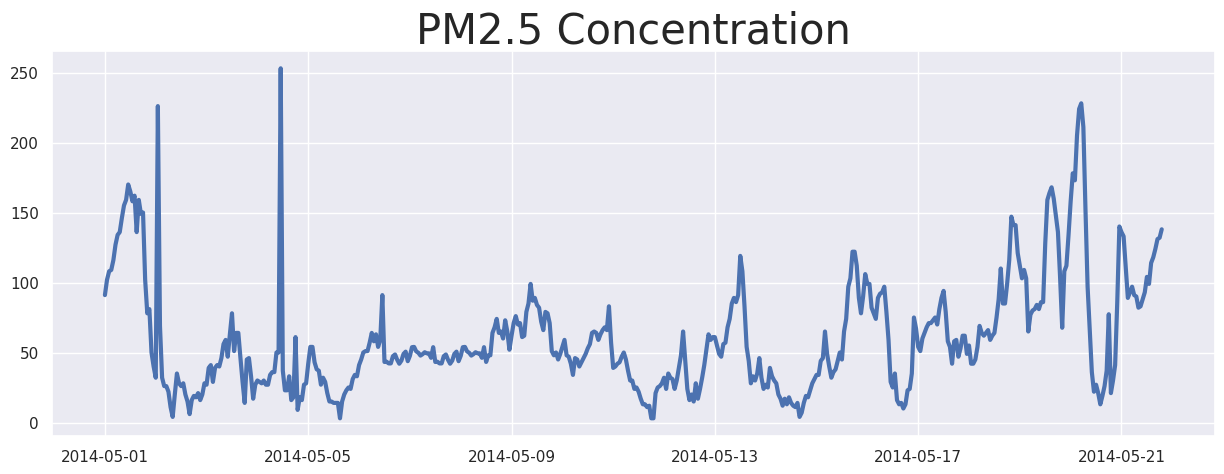

In [55]:
import seaborn as sns
import pandas as pd

leng = 500

cur_data = pd.DataFrame({
    'x': dataset.dataframe().index[:leng],
    'y': features_raw[:leng, 7].numpy(),
})

fig, ax = plt.subplots(figsize=(15, 5))
# sns.set_style("darkgrid")
sns.set_theme()
plot = sns.lineplot(data=cur_data, x = 'x', y="y", ax=ax, linewidth=3)
plot.set(xlabel=None, ylabel=None)
plt.title('PM2.5 Concentration', fontsize=30)
plt.show()
# plot.tick_params(left=False, bottom=False)

In [77]:
from scipy.sparse import coo_matrix

features_raw = torch.tensor(dataset.dataframe().values).T
adj_coo = coo_matrix(adj)
values = adj_coo.data  
indices = np.vstack((adj_coo.row, adj_coo.col))
edge_index  = torch.LongTensor(indices)
n_V,n_E = len(adj), len(edge_index[0])


In [78]:
DIFF = features_raw[:,edge_index[0]]-features_raw[:,edge_index[1]]
DIFF = (DIFF+1)/(features_raw[:,edge_index[0]]+1)
DIFF_ABS = np.absolute(DIFF)

eplision=0.02
print(DIFF.shape)
number = DIFF.shape[0]*DIFF.shape[1]
# print( len(DIFF[np.isnan(DIFF)])/number)
# print( len(DIFF[np.isinf(DIFF)])/number)
print(DIFF_ABS.mean(),DIFF_ABS.std())
print('Intra grpah homophily:',((DIFF_ABS<=eplision).sum())/number)
print('Intra grpah homophily pos:',((DIFF>eplision).sum())/number)
print('Intra grpah homophily neg:',((DIFF<-eplision).sum())/number)

torch.Size([716, 11590])
tensor(1.4786) tensor(7.8980)
Intra grpah homophily: tensor(0.0380)
Intra grpah homophily pos: tensor(0.5028)
Intra grpah homophily neg: tensor(0.4591)


In [79]:
EXPAND_DATA = features_raw[:,edge_index[0]]
sign = EXPAND_DATA[1:]-EXPAND_DATA[:-1]
sign = (sign+1)/(EXPAND_DATA[:-1]+1)
sign_abs = np.absolute(sign)
print(sign.shape)

number = sign.shape[0]*sign.shape[1]
print(sign_abs.mean(),sign_abs.std())
print('Inter grpah homophily:',((sign_abs<=eplision).sum())/number)
print('Inter grpah homophily pos:',((sign>eplision).sum())/number)
print('Inter grpah homophily neg:',((sign<-eplision).sum())/number)

torch.Size([715, 11590])
tensor(2.9403) tensor(30.8253)
Inter grpah homophily: tensor(0.0846)
Inter grpah homophily pos: tensor(0.4756)
Inter grpah homophily neg: tensor(0.4398)


In [23]:
import networkx as nx
from utils import closest_distances_unweighted

# masked = [3, 6, 8, 9, 14, 18, 21, 23, 26, 29, 30, 34, 35, 38, 41, 43, 44, 45, 46, 50, 59, 64, 65, 66, 76, 77, 81, 82, 84, 86, 87, 88, 89, 90, 99, 100, 104, 106, 112, 121, 124, 126, 130, 131, 134, 146, 148, 149, 150, 151, 152, 153, 158, 165, 170, 172, 174, 180, 181, 182, 184, 185, 186, 189, 197, 200, 202, 203, 204]
masked = [175, 176, 177, 179, 203, 220, 224, 226, 227, 232, 288, 289, 290, 304, 305, 306, 307, 308, 309, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 359, 360, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436]
unmask = [i for i in range(adj.shape[0]) if i not in masked]
masked = list(range(adj.shape[0]))

numpy_graph = nx.from_numpy_array(adj)
closeness = nx.closeness_centrality(numpy_graph)
init_hops = closest_distances_unweighted(numpy_graph, masked, unmask)

In [3]:
import os
from utils import month_splitter

def load_model_and_infer(og_path: str, index, dev, node_features=None):
    torch.set_float32_matmul_precision('high')
    
    result = []
    for root, dirs, files in os.walk(og_path):
        for name in files:
            if 'ckpt' in name:
                result.append(os.path.join(root, name))
    
    print(result)
    assert len(result)
    checkpoint_path = result[index]
    
    # Load configuration
    cfg = OmegaConf.load(os.path.join(og_path, 'config.yaml'))
    print(cfg.seed)
    torch.manual_seed(cfg.seed)
    np.random.seed(cfg.seed)
    random.seed(cfg.seed)
    
    # Load dataset
    dataset, masked_sensors = get_dataset(cfg.dataset.name,
                            p_fault=cfg.dataset.get('p_fault'),
                            p_noise=cfg.dataset.get('p_noise'),
                            t_range=cfg.dataset.get('t_range'),
                            masked_s=cfg.dataset.get('masked_sensors'),
                            agg_func=cfg.dataset.get('agg_func'),
                            test_month=cfg.dataset.get('test_month'),
                            location=cfg.dataset.get('location'),
                            connectivity=cfg.dataset.get('connectivity'),
                            mode=cfg.dataset.get('mode'),
                            spatial_shift=cfg.dataset.get('spatial_shift'),
                            order=cfg.dataset.get('order'),
                            node_features=cfg.dataset.get('node_features') if node_features is None else node_features)
    print(f'Masked sensors: {masked_sensors}')
    # covariates = {'u': dataset.datetime_encoded('day').values}

    if cfg.model.name in MODELS:
        adj = dataset.get_connectivity(**cfg.dataset.connectivity, layout='dense')
    else:
        adj = dataset.get_connectivity(**cfg.dataset.connectivity)
    
    torch_dataset = ImputationDataset(
        target=dataset.dataframe(),
        mask=dataset.training_mask,
        eval_mask=dataset.eval_mask,
        # covariates=covariates,
        transform=MaskInput(),
        connectivity=adj,
        window=cfg.window,
        stride=cfg.stride
    )
    
    scalers = {'target': StandardScaler(axis=(0, 1))}

    if cfg.dataset.get('shift', False):
        dataset.get_splitter = month_splitter

        dm = SpatioTemporalDataModule(
            dataset=torch_dataset,
            scalers=scalers,
            splitter=dataset.get_splitter(**cfg.dataset.splitting),
            batch_size=cfg.batch_size,
            workers=cfg.workers)
    else:
        val_len = cfg.dataset.splitting.get('val_len')
        test_len = cfg.dataset.splitting.get('test_len')
        dm = SpatioTemporalDataModule(
            dataset=torch_dataset,
            scalers=scalers,
            splitter=dataset.get_splitter(val_len=val_len, test_len=test_len),
            batch_size=cfg.batch_size,
            workers=cfg.workers)
    
    dm.setup(stage='test')
    
    # Load model
    model_cls = get_model_class(cfg.model.name)
    
    if cfg.model.name == 'kits':
        model_kwargs = dict(adj=adj, d_in=dm.n_channels, n_nodes=dm.n_nodes, args=cfg.model)
    elif cfg.model.name == 'unkrig':
        model_kwargs = dict(adj=adj, input_size=dm.n_channels, output_size=dm.n_channels, horizon=cfg.window)
    elif cfg.model.name == 'unkrigv2':
        model_kwargs = dict(adj=adj, input_size=dm.n_channels, output_size=dm.n_channels, horizon=cfg.window)
    elif cfg.model.name == 'unkrigv3':
        model_kwargs = dict(adj=adj, input_size=dm.n_channels, output_size=dm.n_channels, horizon=cfg.window)
    elif cfg.model.name == 'unkrigv4':
        model_kwargs = dict(adj=adj, input_size=dm.n_channels, output_size=dm.n_channels, horizon=cfg.window)
    elif cfg.model.name == 'unkrigv5':
        model_kwargs = dict(adj=adj, input_size=dm.n_channels, output_size=dm.n_channels, horizon=cfg.window)
    elif cfg.model.name == 'ignnk':
        model_kwargs = dict(h=cfg.window)
    elif cfg.model.name == 'dida':
        model_kwargs = dict(nfeat=dm.n_channels, output_size=dm.n_channels, 
                            num_nodes=adj.shape[0], args=cfg.model.hparams)
    elif cfg.model.name == 'caustg':
        model_kwargs = dict(in_dim=dm.n_channels, out_dim=cfg.window, args=cfg.model.hparams)
    elif cfg.model.name == 'lsjstn':
        model_kwargs = dict(in_dim=dm.n_channels)
    elif cfg.model.name == 'dysat':
        model_kwargs = dict(num_features=dm.n_channels, time_length=cfg.window)
    elif cfg.model.name == 'eagle':
        model_kwargs = dict(nfeat=dm.n_channels, output_size=dm.n_channels, 
                            num_nodes=adj.shape[0], args=cfg.model.hparams)
    elif cfg.model.name == "dcrnn" or cfg.model.name == "evolvegcn":
        model_kwargs = dict(input_size=torch_dataset.n_channels,
                            output_size=dm.n_channels,
                            horizon=cfg.window)
    elif cfg.model.name == 'increase':
        model_kwargs = dict(input_size=dm.n_channels, output_size=dm.n_channels, horizon=cfg.window)
    else:
        model_kwargs = dict(n_nodes=torch_dataset.n_nodes,
                            input_size=torch_dataset.n_channels)
        
    model_cls.filter_model_args_(model_kwargs)
    model_kwargs.update(cfg.model.hparams)
    trainer = Trainer(
        max_epochs=cfg.epochs,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=[dev],
        gradient_clip_val=cfg.get('grad_clip_val', None),
        gradient_clip_algorithm=cfg.get('grad_clip_alg', None))
    print(model_cls)
    
    if cfg.model.name == 'kits':
        imputer = GCNCycVirtualFiller.load_from_checkpoint(checkpoint_path, model_class=model_cls, model_kwargs=model_kwargs,
                                                            gradient_clip_val=cfg.grad_clip_val,
                                                            gradient_clip_algorithm=cfg.grad_clip_alg,
                                                            known_nodes = [i for i in range(adj.shape[0]) if i not in masked_sensors],
                                                            **cfg.model.technique)
    elif cfg.model.name == "unkrig":
        imputer = UnnamedKrigFiller.load_from_checkpoint(checkpoint_path, model_class=model_cls,
                                    model_kwargs=model_kwargs,
                                    gradient_clip_val=cfg.grad_clip_val,
                                    gradient_clip_algorithm=cfg.grad_clip_alg,
                                    known_set = [i for i in range(adj.shape[0]) if i not in masked_sensors],
                                    **cfg.model.regs)
    elif cfg.model.name == "unkrigv2" or cfg.model.name == "unkrigv3":
        imputer = UnnamedKrigFillerV2.load_from_checkpoint(checkpoint_path, model_class=model_cls,
                                    model_kwargs=model_kwargs,
                                    gradient_clip_val=cfg.grad_clip_val,
                                    gradient_clip_algorithm=cfg.grad_clip_alg,
                                    known_set = [i for i in range(adj.shape[0]) if i not in masked_sensors],
                                    **cfg.model.regs)
    elif cfg.model.name == "unkrigv5":
        imputer = UnnamedKrigFillerV5.load_from_checkpoint(checkpoint_path, model_class=model_cls,
                                    model_kwargs=model_kwargs,
                                    gradient_clip_val=cfg.grad_clip_val,
                                    gradient_clip_algorithm=cfg.grad_clip_alg,
                                    known_set = [i for i in range(adj.shape[0]) if i not in masked_sensors],
                                    **cfg.model.regs)
    elif cfg.model.name == "dida":
        imputer = DidaFiller.load_from_checkpoint(checkpoint_path, model_class=model_cls,
                            model_kwargs=model_kwargs,
                            gradient_clip_val=cfg.grad_clip_val,
                            gradient_clip_algorithm=cfg.grad_clip_alg,
                            known_set = [i for i in range(adj.shape[0]) if i not in masked_sensors],
                            adj=adj,
                            horizon=cfg.window,
                            **cfg.model.regs)
    elif cfg.model.name == "ignnk":
        imputer = IGNNKFiller.load_from_checkpoint(checkpoint_path, model_class=model_cls,
                            model_kwargs=model_kwargs,
                            gradient_clip_val=cfg.grad_clip_val,
                            gradient_clip_algorithm=cfg.grad_clip_alg,
                            known_set = [i for i in range(adj.shape[0]) if i not in masked_sensors],
                            adj=adj,
                            n_o_n_m=cfg.model.n_o_n_m)
    elif cfg.model.name == "eagle":
        imputer = EAGLEfiller.load_from_checkpoint(checkpoint_path, model_class=model_cls,
                            model_kwargs=model_kwargs,
                            gradient_clip_val=cfg.grad_clip_val,
                            gradient_clip_algorithm=cfg.grad_clip_alg,
                            known_set = [i for i in range(adj.shape[0]) if i not in masked_sensors],
                            adj=adj,
                            horizon=cfg.window,
                            **cfg.model.regs)
    elif cfg.model.name == "caustg":
        imputer = CauSTGFiller.load_from_checkpoint(checkpoint_path, model_class=model_cls,
                            model_kwargs=model_kwargs,
                            gradient_clip_val=cfg.grad_clip_val,
                            gradient_clip_algorithm=cfg.grad_clip_alg,
                            known_set = [i for i in range(adj.shape[0]) if i not in masked_sensors],
                            adj=adj,
                            device=cfg.device,
                            **cfg.model.regs)
    elif cfg.model.name == "lsjstn":
        imputer = LSJSTNFiller.load_from_checkpoint(checkpoint_path, model_class=model_cls,
                            model_kwargs=model_kwargs,
                            gradient_clip_val=cfg.grad_clip_val,
                            gradient_clip_algorithm=cfg.grad_clip_alg,
                            known_set = [i for i in range(adj.shape[0]) if i not in masked_sensors],
                            adj=adj)
    elif cfg.model.name == "dysat":
        imputer = DYSATFiller.load_from_checkpoint(checkpoint_path, model_class=model_cls,
                            model_kwargs=model_kwargs,
                            known_set = [i for i in range(adj.shape[0]) if i not in masked_sensors],
                            adj=adj,
                            horizon=cfg.window)
    elif cfg.model.name == "dcrnn" or cfg.model.name == "evolvegcn":
        imputer = StandardFiller.load_from_checkpoint(checkpoint_path, model_class=model_cls,
                                model_kwargs=model_kwargs,
                                known_set = [i for i in range(adj.shape[0]) if i not in masked_sensors],
                                adj=adj,
                                horizon=cfg.window)
    elif cfg.model.name == "increase":
        imputer = INCREASEFiller.load_from_checkpoint(checkpoint_path, model_class=model_cls,
                                model_kwargs=model_kwargs,
                                known_set = [i for i in range(adj.shape[0]) if i not in masked_sensors],
                                adj=adj,
                                horizon=cfg.window,
                                num_n=cfg.model.hparams.K)
    else:
        imputer = Imputer.load_from_checkpoint(checkpoint_path, model_class=model_cls, model_kwargs=model_kwargs)

    imputer.to(torch.device(f'cuda:{dev}'))
    imputer.eval()

    # trainer.test(imputer, datamodule=dm)
    
    # # Run inference
    # trainer = torch.utils.data.DataLoader(dm.test_dataloader(), batch_size=cfg.batch_size)
    output = trainer.predict(imputer, dataloaders=dm.test_dataloader())
    output = imputer.collate_prediction_outputs(output)
    output = torch_to_numpy(output)
    
    y_hat, y_true, mask, adj_invar, adj_var, sum_out = (output['y_hat'], output['y'],
                                                        output.get('eval_mask', None),
                                                        output.get('inv_adj', None),
                                                        output.get('var_adj', None),
                                                        output.get('sum_out', None))
    # mask[:, :, 12, :] = 0
    # mask[:, :, 4, :] = True
    res = dict(test_mae=numpy_metrics.mae(y_hat, y_true, mask),
               test_mre=numpy_metrics.mre(y_hat, y_true, mask),
               test_mape=numpy_metrics.mape(y_hat, y_true, mask),
               test_rmse=numpy_metrics.rmse(y_hat, y_true, mask))

    # return output[-2], output[-1]
    
    return y_hat, y_true, mask, res, dm, dataset, model_cls, adj, [i for i in range(adj.shape[0]) if i not in masked_sensors]


In [4]:
def graph_eval(y_hat, y_true, mask, known_nodes, adj, num_groups = 5):
    numpy_graph = nx.from_numpy_array(adj)
    k_nodes = np.array(known_nodes)
    u_nodes = np.array([i for i in range(adj.shape[0]) if i not in known_nodes])

    khr_grouped = closest_distances_unweighted(numpy_graph, u_nodes, k_nodes.tolist())
    khr_grouped = {node: score for node, score in khr_grouped.items() if score < 1e9}
    khr_gr = [[] for _ in range(num_groups)]

    for key, pos in khr_grouped.items():
        value = pos-1
        if value < num_groups:
            khr_gr[value].append(key)
        else:
            khr_gr[num_groups-1].append(key)

    results = {'mae':[], 'mre':[], 'rmse':[]}
    for group in khr_gr[:-1]:
        node_mask = np.zeros_like(mask, dtype=bool)
        node_mask[:, :, group] = True
        masked_adj = mask * node_mask

        # nonzero_mask = masked_adj != 0  # shape: D x T x N
        # active_n = np.any(nonzero_mask, axis=(0, 1, 3))  # shape: N
        # nonzero_n_indices = np.where(active_n)[0]
        # print(nonzero_n_indices)

        results['mae'].append(numpy_metrics.mae(y_hat, y_true, masked_adj))
        results['mre'].append(numpy_metrics.mre(y_hat, y_true, masked_adj))
        results['rmse'].append(numpy_metrics.rmse(y_hat, y_true, masked_adj))
    
    return results

In [25]:
paths = ['../logs/ignnk/aqi/2025-06-30/18-19-25', '../logs/ignnk/aqi/2025-06-30/17-17-21', '../logs/ignnk/aqi/2025-06-30/16-27-19', 
          '../logs/dcrnn/aqi/2025-07-05/10-48-03', '../logs/dcrnn/aqi/2025-07-05/07-21-37', '../logs/dcrnn/aqi/2025-07-05/08-46-50',
          '../logs/kits/aqi/2025-07-06/22-45-12', '../logs/kits/aqi/2025-07-07/00-25-17', '../logs/kits/aqi/2025-07-07/01-53-02',
          '../logs/increase/aqi/2025-07-04/11-35-22', '../logs/increase/aqi/2025-07-04/11-08-44', '../logs/increase/aqi/2025-07-04/11-20-19']

paths = ['../logs/ignnk/metrla/2025-07-03/04-00-16', '../logs/ignnk/metrla/2025-07-03/17-56-42', '../logs/ignnk/metrla/2025-07-04/01-53-14',
         '../logs/dcrnn/metrla/2025-07-05/20-35-28', '../logs/dcrnn/metrla/2025-07-05/22-41-39', '../logs/dcrnn/metrla/2025-07-06/00-19-22',
         '../logs/kits/metrla/2025-07-10/06-06-39', '../logs/kits/metrla/2025-07-10/00-09-06', '../logs/kits/metrla/2025-07-09/17-48-34',
         '../logs/increase/metrla/2025-07-04/14-20-25', '../logs/increase/metrla/2025-07-04/14-34-16', '../logs/increase/metrla/2025-07-04/15-04-50']

deets = []
for path in paths:
    res = load_model_and_infer(path, 0, 3, node_features='degree')
    fin_res = graph_eval(res[0], res[1], res[2], res[-1], res[7])
    deets.append(fin_res)
    print(res[3])
    print(fin_res)

['../logs/ignnk/metrla/2025-07-03/04-00-16/epoch=43-step=16896.ckpt', '../logs/ignnk/metrla/2025-07-03/04-00-16/epoch=99-last.ckpt']
10799678


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Masked sensors: [8, 18, 21, 23, 25, 29, 31, 34, 35, 36, 44, 45, 46, 50, 51, 52, 56, 59, 61, 65, 66, 83, 86, 90, 92, 99, 100, 104, 106, 112, 120, 121, 126, 147, 149, 150, 152, 153, 156, 165, 174, 180, 181, 182, 184, 185, 186, 189, 194, 200, 202, 203]
<class 'baselines.IGNNK.IGNNK'>


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|██████████| 108/108 [00:02<00:00, 50.38it/s]
{'test_mae': 6.228161, 'test_mre': 0.10488492478737181, 'test_mape': 0.16901088, 'test_rmse': 8.99825}
{'mae': [6.040895, 8.070479, 5.510802, nan], 'mre': [0.10233142360771584, 0.13092749870288217, 0.09268763451006846, 0.0], 'rmse': [8.892904, 11.0335655, 6.8479266, nan]}
['../logs/ignnk/metrla/2025-07-03/17-56-42/epoch=58-last.ckpt', '../logs/ignnk/metrla/2025-07-03/17-56-42/epoch=31-last.ckpt', '../logs/ignnk/metrla/2025-07-03/17-56-42/epoch=33-step=13056.ckpt']
72833750


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Masked sensors: [8, 18, 21, 23, 25, 29, 31, 34, 35, 36, 44, 45, 46, 50, 51, 52, 56, 59, 61, 65, 66, 83, 86, 90, 92, 99, 100, 104, 106, 112, 120, 121, 126, 147, 149, 150, 152, 153, 156, 165, 174, 180, 181, 182, 184, 185, 186, 189, 194, 200, 202, 203]
<class 'baselines.IGNNK.IGNNK'>


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|██████████| 108/108 [00:02<00:00, 52.92it/s]
{'test_mae': 6.321863, 'test_mre': 0.1064629129173648, 'test_mape': 0.16827013, 'test_rmse': 9.070707}
{'mae': [6.1448503, 8.41552, 5.218296, nan], 'mre': [0.10409240423651184, 0.13652509602813448, 0.0877679037076299, 0.0], 'rmse': [8.994944, 11.156439, 6.50652, nan]}
['../logs/ignnk/metrla/2025-07-04/01-53-14/epoch=76-step=29568.ckpt', '../logs/ignnk/metrla/2025-07-04/01-53-14/epoch=99-last.ckpt']
53728009


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Masked sensors: [8, 18, 21, 23, 25, 29, 31, 34, 35, 36, 44, 45, 46, 50, 51, 52, 56, 59, 61, 65, 66, 83, 86, 90, 92, 99, 100, 104, 106, 112, 120, 121, 126, 147, 149, 150, 152, 153, 156, 165, 174, 180, 181, 182, 184, 185, 186, 189, 194, 200, 202, 203]
<class 'baselines.IGNNK.IGNNK'>


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|██████████| 108/108 [00:01<00:00, 57.54it/s]
{'test_mae': 6.069855, 'test_mre': 0.10221898224850358, 'test_mape': 0.16165136, 'test_rmse': 8.834732}
{'mae': [5.8531156, 7.8957586, 5.6097198, nan], 'mre': [0.09915048754031708, 0.12809300803628573, 0.09435136348471272, 0.0], 'rmse': [8.688724, 10.953326, 6.9291444, nan]}
['../logs/dcrnn/metrla/2025-07-05/20-35-28/epoch=1-step=768.ckpt', '../logs/dcrnn/metrla/2025-07-05/20-35-28/epoch=26-last.ckpt']
15900376


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Masked sensors: [8, 18, 21, 23, 25, 29, 31, 34, 35, 36, 44, 45, 46, 50, 51, 52, 56, 59, 61, 65, 66, 83, 86, 90, 92, 99, 100, 104, 106, 112, 120, 121, 126, 147, 149, 150, 152, 153, 156, 165, 174, 180, 181, 182, 184, 185, 186, 189, 194, 200, 202, 203]
<class 'baselines.DCRNN.DCRNNModel'>


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|██████████| 108/108 [00:24<00:00,  4.42it/s]
{'test_mae': 5.544362, 'test_mre': 0.09336945776471582, 'test_mape': 0.16437219, 'test_rmse': 9.211485}
{'mae': [5.524872, 5.8062353, 5.3849945, nan], 'mre': [0.0935901085988259, 0.09419463822510793, 0.09057165314119246, 0.0], 'rmse': [9.182304, 10.516134, 7.6210628, nan]}
['../logs/dcrnn/metrla/2025-07-05/22-41-39/epoch=1-step=768.ckpt', '../logs/dcrnn/metrla/2025-07-05/22-41-39/epoch=26-last.ckpt']
63273150
Masked sensors: [8, 18, 21, 23, 25, 29, 31, 34, 35, 36, 44, 45, 46, 50, 51, 52, 56, 59, 61, 65, 66, 83, 86, 90, 92, 99, 100, 104, 106, 112, 120, 121, 126, 147, 149, 150, 152, 153, 156, 165, 174, 180, 181, 182, 184, 185, 186, 189, 194, 200, 202, 203]


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<class 'baselines.DCRNN.DCRNNModel'>


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|██████████| 108/108 [00:22<00:00,  4.90it/s]
{'test_mae': 5.5772114, 'test_mre': 0.09392265078503022, 'test_mape': 0.15863456, 'test_rmse': 9.012972}
{'mae': [5.52158, 6.188527, 5.2867484, nan], 'mre': [0.09353435239947802, 0.10039656775333583, 0.088919227436334, 0.0], 'rmse': [8.954568, 10.548006, 7.3083024, nan]}
['../logs/dcrnn/metrla/2025-07-06/00-19-22/epoch=2-step=1152.ckpt', '../logs/dcrnn/metrla/2025-07-06/00-19-22/epoch=27-last.ckpt']
10799678


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Masked sensors: [8, 18, 21, 23, 25, 29, 31, 34, 35, 36, 44, 45, 46, 50, 51, 52, 56, 59, 61, 65, 66, 83, 86, 90, 92, 99, 100, 104, 106, 112, 120, 121, 126, 147, 149, 150, 152, 153, 156, 165, 174, 180, 181, 182, 184, 185, 186, 189, 194, 200, 202, 203]
<class 'baselines.DCRNN.DCRNNModel'>


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|██████████| 108/108 [00:25<00:00,  4.22it/s]
{'test_mae': 5.48598, 'test_mre': 0.09238627167954017, 'test_mape': 0.16193901, 'test_rmse': 9.15536}
{'mae': [5.4578266, 5.901519, 5.2107463, nan], 'mre': [0.09245437364487814, 0.09574042562918152, 0.08764092143143486, 0.0], 'rmse': [9.189112, 10.456036, 6.9294996, nan]}
['../logs/kits/metrla/2025-07-10/06-06-39/epoch=6-step=2688.ckpt', '../logs/kits/metrla/2025-07-10/06-06-39/epoch=31-last.ckpt']
53728009


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Masked sensors: [8, 18, 21, 23, 25, 29, 31, 34, 35, 36, 44, 45, 46, 50, 51, 52, 56, 59, 61, 65, 66, 83, 86, 90, 92, 99, 100, 104, 106, 112, 120, 121, 126, 147, 149, 150, 152, 153, 156, 165, 174, 180, 181, 182, 184, 185, 186, 189, 194, 200, 202, 203]
<class 'baselines.KITS.KITS'>


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|██████████| 108/108 [00:18<00:00,  5.78it/s]
{'test_mae': 5.805976, 'test_mre': 0.09777514204740625, 'test_mape': 0.16756961, 'test_rmse': 9.4602}
{'mae': [5.8594394, 5.4361377, 5.822162, nan], 'mre': [0.09925760895728757, 0.08819054041318683, 0.09792448804294712, 0.0], 'rmse': [9.4234, 10.722182, 8.020159, nan]}
['../logs/kits/metrla/2025-07-10/00-09-06/epoch=6-step=2688.ckpt', '../logs/kits/metrla/2025-07-10/00-09-06/epoch=31-last.ckpt']
72833750


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Masked sensors: [8, 18, 21, 23, 25, 29, 31, 34, 35, 36, 44, 45, 46, 50, 51, 52, 56, 59, 61, 65, 66, 83, 86, 90, 92, 99, 100, 104, 106, 112, 120, 121, 126, 147, 149, 150, 152, 153, 156, 165, 174, 180, 181, 182, 184, 185, 186, 189, 194, 200, 202, 203]
<class 'baselines.KITS.KITS'>


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|██████████| 108/108 [00:19<00:00,  5.56it/s]
{'test_mae': 5.7580233, 'test_mre': 0.0969676033563468, 'test_mape': 0.16780637, 'test_rmse': 9.590855}
{'mae': [5.711479, 5.8757596, 5.9906836, nan], 'mre': [0.09675119835568276, 0.09532253329046832, 0.10075889875392556, 0.0], 'rmse': [9.510403, 11.080561, 8.195103, nan]}
['../logs/kits/metrla/2025-07-09/17-48-34/epoch=6-step=2688.ckpt', '../logs/kits/metrla/2025-07-09/17-48-34/epoch=31-last.ckpt']
10799678


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Masked sensors: [8, 18, 21, 23, 25, 29, 31, 34, 35, 36, 44, 45, 46, 50, 51, 52, 56, 59, 61, 65, 66, 83, 86, 90, 92, 99, 100, 104, 106, 112, 120, 121, 126, 147, 149, 150, 152, 153, 156, 165, 174, 180, 181, 182, 184, 185, 186, 189, 194, 200, 202, 203]
<class 'baselines.KITS.KITS'>


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|██████████| 108/108 [00:18<00:00,  5.83it/s]
{'test_mae': 5.793994, 'test_mre': 0.09757336132940606, 'test_mape': 0.17474705, 'test_rmse': 9.612327}
{'mae': [5.766449, 5.9549217, 5.821444, nan], 'mre': [0.09768237033118149, 0.09660677967581147, 0.09791240883148546, 0.0], 'rmse': [9.6021, 10.752632, 8.119428, nan]}
['../logs/increase/metrla/2025-07-04/14-20-25/epoch=1-step=768.ckpt', '../logs/increase/metrla/2025-07-04/14-20-25/epoch=10-last.ckpt']
15900376


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Masked sensors: [8, 18, 21, 23, 25, 29, 31, 34, 35, 36, 44, 45, 46, 50, 51, 52, 56, 59, 61, 65, 66, 83, 86, 90, 92, 99, 100, 104, 106, 112, 120, 121, 126, 147, 149, 150, 152, 153, 156, 165, 174, 180, 181, 182, 184, 185, 186, 189, 194, 200, 202, 203]
<class 'baselines.INCREASE.INCREASE'>


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|██████████| 108/108 [00:06<00:00, 17.60it/s]
{'test_mae': 6.432068, 'test_mre': 0.10831880377173196, 'test_mape': 0.18645129, 'test_rmse': 9.661893}
{'mae': [6.473813, 7.2829103, 5.0679674, nan], 'mre': [0.10966496554550728, 0.11815075991790162, 0.08523948617559138, 0.0], 'rmse': [9.828443, 10.624467, 6.60438, nan]}
['../logs/increase/metrla/2025-07-04/14-34-16/epoch=5-step=2304.ckpt', '../logs/increase/metrla/2025-07-04/14-34-16/epoch=23-last.ckpt']
63273150


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Masked sensors: [8, 18, 21, 23, 25, 29, 31, 34, 35, 36, 44, 45, 46, 50, 51, 52, 56, 59, 61, 65, 66, 83, 86, 90, 92, 99, 100, 104, 106, 112, 120, 121, 126, 147, 149, 150, 152, 153, 156, 165, 174, 180, 181, 182, 184, 185, 186, 189, 194, 200, 202, 203]
<class 'baselines.INCREASE.INCREASE'>


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|██████████| 108/108 [00:06<00:00, 17.03it/s]
{'test_mae': 6.539238, 'test_mre': 0.11012359407960438, 'test_mape': 0.1825551, 'test_rmse': 9.618722}
{'mae': [6.5727396, 7.4965982, 5.11285, nan], 'mre': [0.1113407564945516, 0.12161742439989709, 0.08599438477645967, 0.0], 'rmse': [9.7630415, 10.709904, 6.5721073, nan]}
['../logs/increase/metrla/2025-07-04/15-04-50/epoch=2-step=1152.ckpt', '../logs/increase/metrla/2025-07-04/15-04-50/epoch=19-last.ckpt']
10799678


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Masked sensors: [8, 18, 21, 23, 25, 29, 31, 34, 35, 36, 44, 45, 46, 50, 51, 52, 56, 59, 61, 65, 66, 83, 86, 90, 92, 99, 100, 104, 106, 112, 120, 121, 126, 147, 149, 150, 152, 153, 156, 165, 174, 180, 181, 182, 184, 185, 186, 189, 194, 200, 202, 203]
<class 'baselines.INCREASE.INCREASE'>


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|██████████| 108/108 [00:06<00:00, 16.98it/s]
{'test_mae': 6.208718, 'test_mre': 0.10455749439729015, 'test_mape': 0.18362765, 'test_rmse': 9.778149}
{'mae': [6.2952733, 6.7260475, 4.886616, nan], 'mre': [0.10664054075021044, 0.10911676234096335, 0.08218929419140707, 0.0], 'rmse': [10.0006485, 10.462727, 6.590015, nan]}


In [26]:
deets

[{'mae': [6.040895, 8.070479, 5.510802, nan],
  'mre': [0.10233142360771584, 0.13092749870288217, 0.09268763451006846, 0.0],
  'rmse': [8.892904, 11.0335655, 6.8479266, nan]},
 {'mae': [6.1448503, 8.41552, 5.218296, nan],
  'mre': [0.10409240423651184, 0.13652509602813448, 0.0877679037076299, 0.0],
  'rmse': [8.994944, 11.156439, 6.50652, nan]},
 {'mae': [5.8531156, 7.8957586, 5.6097198, nan],
  'mre': [0.09915048754031708, 0.12809300803628573, 0.09435136348471272, 0.0],
  'rmse': [8.688724, 10.953326, 6.9291444, nan]},
 {'mae': [5.524872, 5.8062353, 5.3849945, nan],
  'mre': [0.0935901085988259, 0.09419463822510793, 0.09057165314119246, 0.0],
  'rmse': [9.182304, 10.516134, 7.6210628, nan]},
 {'mae': [5.52158, 6.188527, 5.2867484, nan],
  'mre': [0.09353435239947802, 0.10039656775333583, 0.088919227436334, 0.0],
  'rmse': [8.954568, 10.548006, 7.3083024, nan]},
 {'mae': [5.4578266, 5.901519, 5.2107463, nan],
  'mre': [0.09245437364487814, 0.09574042562918152, 0.08764092143143486, 0.0]

In [27]:
deets
mae_data = []
for deet in deets:
    mae_data.append(deet['mae'])

In [3]:
aqi_data = np.array([[29.321598, 46.91735, 45.1897, 42.428673],
 [29.416298, 47.62053, 45.32964, 39.801853],
 [28.853184, 46.021065, 45.923237, 44.173893],

 [18.678604, 27.80927, 30.315912, 28.500082],
 [18.724499, 28.92365, 30.626307, 28.650051],
 [18.176779, 29.209793, 31.7795, 29.316355],

 [19.09695, 34.76117, 36.29995, 33.924595],
 [19.959896, 34.096348, 35.045322, 32.359413],
 [21.407982, 31.858835, 32.512806, 30.366863],

 [24.587656, 35.403732, 34.29621, 31.485807],
 [23.127468, 34.443874, 33.41798, 30.97206],
 [21.785913, 40.441784, 39.124535, 35.508812]])

metrla_data = np.array([[6.040895, 8.070479, 5.510802],
 [6.1448503, 8.41552, 5.218296],
 [5.8531156, 7.8957586, 5.6097198],

 [5.524872, 5.8062353, 5.3849945],
 [5.52158, 6.188527, 5.2867484],
 [5.4578266, 5.901519, 5.2107463],

 [5.8594394, 5.4361377, 5.822162],
 [5.711479, 5.8757596, 5.9906836],
 [5.766449, 5.9549217, 5.821444],

 [6.473813, 7.2829103, 5.0679674],
 [6.5727396, 7.4965982, 5.11285],
 [6.2952733, 6.7260475, 4.886616]])

In [4]:
aqi_data = aqi_data.reshape(4, 3, -1).transpose(1, 2, 0)
metrla_data = metrla_data.reshape(4, 3, -1).transpose(1, 2, 0)

[0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3 0
 1 2 3 0 1 2 3 0 1 2 3]
[0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3]


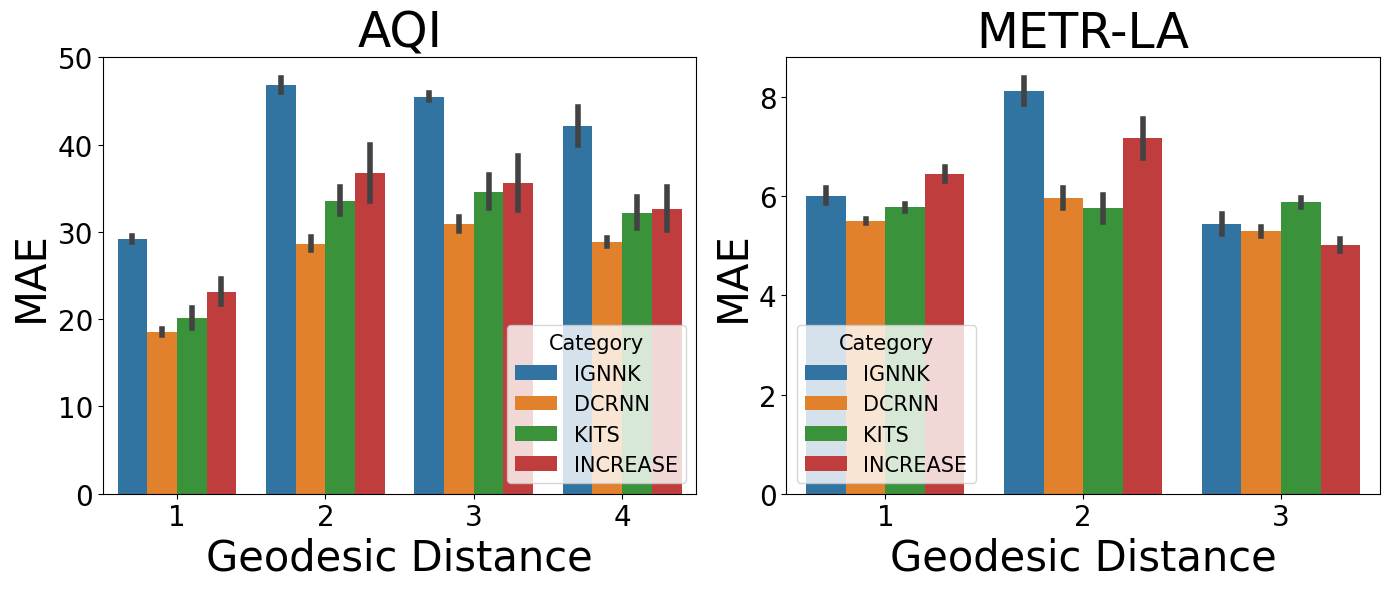

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def reshape_data(data, label):
    s, b, c = data.shape
    print(np.tile(np.arange(c), s * b),)
    return pd.DataFrame({
        'sample': np.repeat(np.arange(s), b * c),
        'bin': np.tile(np.repeat(np.arange(1, b+1), c), s),
        'category': ['IGNNK', 'DCRNN', 'KITS', 'INCREASE'] * (s * b),
        'value': data.reshape(-1),
        'dataset': label
    })

# Prepare dataframes
df1 = reshape_data(aqi_data, 'Dataset 1')
df2 = reshape_data(metrla_data, 'Dataset 2')

# Combine but keep them separate for subplots
df1['bin'] = df1['bin'].astype(str)
df1['category'] = df1['category'].astype(str)
df2['bin'] = df2['bin'].astype(str)
df2['category'] = df2['category'].astype(str)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

# Plot Dataset 1
sns.barplot(data=df1, x='bin', y='value', hue='category', ci='sd', ax=axes[0], errwidth=4)
axes[0].set_title('AQI', fontsize=35)
axes[0].set_xlabel('Geodesic Distance', fontsize=30)
axes[0].set_ylabel('MAE', fontsize=30)
axes[0].legend(title='Category', title_fontsize=15, fontsize=15, loc='lower right')
axes[0].tick_params(labelsize=20)

# Plot Dataset 2
sns.barplot(data=df2, x='bin', y='value', hue='category', ci='sd', ax=axes[1], errwidth=4)
axes[1].set_title('METR-LA', fontsize=35)
axes[1].set_xlabel('Geodesic Distance', fontsize=30)
axes[1].set_ylabel('MAE', fontsize=30)
axes[1].legend(title='Category', title_fontsize=15, fontsize=15)
axes[1].tick_params(labelsize=20)

plt.tight_layout()
plt.savefig('geodesic_dist.pdf', dpi=300, bbox_inches='tight')

In [5]:
# paths = ['../logs/kits/metrla/2025-04-03/transfer1']
paths = ['../logs/unkrig/air/2025-04-09/15-08-32']
paths = ['../logs/kits/metrla/2025-04-03/14-28-14', '../logs/unkrig/metrla/2025-04-16/17-24-43']
paths = ['../logs/unkrig/air/2025-05-02/15-59-51', '../logs/kits/air/2025-05-02/00-40-52']
# paths = ['../logs/unkrig/metrla/2025-04-29/11-54-31', '../logs/kits/metrla/2025-04-21/14-44-49']
# paths = ['../logs/unkrig/air/2025-05-07/15-36-40', '../logs/kits/air/2025-05-02/00-40-52']
paths = ['../logs/unkrig/metrla/2025-05-07/23-28-11', '../logs/kits/metrla/2025-05-14/15-07-38']
paths = ['../logs/unkrigv2/metrla/2025-05-18/21-02-53']
paths = ['../logs/unkrigv5/aqi/2025-07-12/13-17-29', '../logs/dcrnn/aqi/2025-07-05/07-21-37']#, '../logs/unkrigv5/metrla/2025-07-02/18-50-38']
# paths = ['../logs/unkrigv5/metrla/2025-06-17/15-25-56', '../logs/kits/metrla/2025-06-03/19-08-15']
# paths = ['../logs/unkrigv3/air/2025-05-23/15-38-02', '../logs/kits/air/2025-05-23/16-53-39', '../logs/unkrigv3/air/2025-05-20/22-57-47']
# paths = ['../logs/unkrigv5/aqi/2025-06-17/10-22-07']

deets = []
# for path in paths:
res = load_model_and_infer(paths[0], 0, 3)
deets.append(res)
print(res[3])
res = load_model_and_infer(paths[1], 0, 3)
deets.append(res)
print(res[3])

# for path in paths:
#     res = load_model_and_infer(path, 0)
#     deets.append(res)
#     print(res[3])

# deets[3] = load_model_and_infer(paths[3])

['../logs/unkrigv5/aqi/2025-07-12/13-17-29/epoch=37-step=5966.ckpt', '../logs/unkrigv5/aqi/2025-07-12/13-17-29/epoch=87-last.ckpt']
15900376
Masked sensors: [28, 31, 60, 167, 169, 171, 175, 176, 177, 178, 179, 180, 181, 182, 183, 203, 206, 220, 221, 222, 224, 226, 227, 230, 232, 233, 234, 235, 236, 237, 238, 239, 240, 242, 243, 245, 246, 247, 249, 250, 253, 256, 258, 259, 279, 304, 305, 306, 307, 308, 309, 311, 313, 316, 320, 330, 331, 332, 333, 334, 335, 336, 337, 339, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 372, 373, 374, 375, 376, 377, 378, 408, 413, 414, 415, 416, 417, 418, 419, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436]


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<class 'unnamedKrig_v5.UnnamedKrigModelV5'>


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|██████████| 178/178 [03:48<00:00,  0.78it/s]
{'test_mae': 21.808855, 'test_mre': 0.437540399316138, 'test_mape': 0.8950173, 'test_rmse': 33.133766}
['../logs/dcrnn/aqi/2025-07-05/07-21-37/epoch=39-step=3120.ckpt', '../logs/dcrnn/aqi/2025-07-05/07-21-37/epoch=64-last.ckpt']
15900376
Masked sensors: [28, 31, 60, 167, 169, 171, 175, 176, 177, 178, 179, 180, 181, 182, 183, 203, 206, 220, 221, 222, 224, 226, 227, 230, 232, 233, 234, 235, 236, 237, 238, 239, 240, 242, 243, 245, 246, 247, 249, 250, 253, 256, 258, 259, 279, 304, 305, 306, 307, 308, 309, 311, 313, 316, 320, 330, 331, 332, 333, 334, 335, 336, 337, 339, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 372, 373, 374, 375, 376, 377, 378, 408, 413, 414, 415, 416, 417, 418, 419, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436]


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


<class 'baselines.DCRNN.DCRNNModel'>


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|██████████| 89/89 [00:38<00:00,  2.30it/s]
{'test_mae': 23.275766, 'test_mre': 0.466970316043518, 'test_mape': 1.1196771, 'test_rmse': 32.985382}


In [8]:
import math
import networkx as nx

def test_wise_eval(y_hat, y_true, mask, known_nodes, adj, mode, num_groups=4, alpha = 0.20):
    numpy_graph = nx.from_numpy_array(adj)
    k_nodes = np.array(known_nodes)
    u_nodes = np.array([i for i in range(adj.shape[0]) if i not in known_nodes])
    m_adj = (adj > 0).astype(float)
    group_size = u_nodes.shape[0] // num_groups

    # LPS
    n = adj.shape[-1]

    A_hat = m_adj
    idx = np.arange(n)
    A_hat[idx, idx] = 1
    D = np.diag(np.sum(A_hat, axis=1))

    D_inv_sqrt = np.linalg.inv(np.sqrt(D))
    A_norm = D_inv_sqrt @ A_hat @ D_inv_sqrt
    I = np.eye(n)

    P = np.linalg.inv((I - (1-alpha)*A_norm))
    T = np.zeros((n, n))
    T[k_nodes, k_nodes] = 1
    ones = np.ones((n,))

    LPS = P @ T @ ones

    sorted_lps = sorted(u_nodes, key=lambda i: LPS[i])
    lps_gr = [sorted_lps[i*group_size : (i+1)*group_size] for i in range(num_groups)]
    remainder = len(sorted_lps) % num_groups
    if remainder:
        lps_gr[-1].extend(sorted_lps[-remainder:])

    # CC
    closeness = nx.closeness_centrality(numpy_graph)

    sorted_cls = sorted(u_nodes, key=lambda i: closeness[i])
    # sorted_cls = [x for x, _ in sorted_cls]
    cls_gr = [sorted_cls[i*group_size : (i+1)*group_size] for i in range(num_groups)]
    remainder = len(sorted_cls) % num_groups
    if remainder:
        cls_gr[-1].extend(sorted_cls[-remainder:])

    # ND
    degrees = dict(nx.degree(numpy_graph))

    sorted_nd = sorted(u_nodes, key=lambda i: degrees[i])
    # sorted_nd = [x for x, _ in sorted_nd]
    nd_gr = [sorted_nd[i*group_size : (i+1)*group_size] for i in range(num_groups)]
    remainder = len(sorted_nd) % num_groups
    if remainder:
        nd_gr[-1].extend(sorted_nd[-remainder:])

    # KHR
    khr_grouped = closest_distances_unweighted(numpy_graph, u_nodes, k_nodes)
    khr_gr = [[] for _ in range(num_groups)]

    for key, pos in khr_grouped.items():
        value = pos-1
        if value < num_groups:
            khr_gr[value].append(key)
        else:
            khr_gr[num_groups-1].append(key)

    # Evaluate
    group_dict = {'LPS': lps_gr,
                'CC': cls_gr,
                'ND': nd_gr,
                'KHR': khr_gr}
    res = {f'{mode}_mae': numpy_metrics.mae(y_hat, y_true, mask),
               f'{mode}_mre': numpy_metrics.mre(y_hat, y_true, mask),
               f'{mode}_rmse': numpy_metrics.rmse(y_hat, y_true, mask)}

    for key, groups in group_dict.items():
        results = {'mae':[], 'mre':[], 'rmse':[]}
        for group in groups:
            node_mask = np.zeros_like(mask, dtype=bool)
            node_mask[:, :, group] = True
            masked_adj = mask * node_mask


            # nonzero_mask = masked_adj != 0  # shape: D x T x N
            # active_n = np.any(nonzero_mask, axis=(0, 1, 3))  # shape: N
            # nonzero_n_indices = np.where(active_n)[0]
            # print(nonzero_n_indices)


            results['mae'].append(numpy_metrics.mae(y_hat, y_true, masked_adj))
            results['mre'].append(numpy_metrics.mre(y_hat, y_true, masked_adj))
            results['rmse'].append(numpy_metrics.rmse(y_hat, y_true, masked_adj))

        for metric, val in results.items():
            wdp_num = 0
            wsd_num = 0
            ntotal = u_nodes.shape[0]

            for ind, a1 in enumerate(val):
                if math.isnan(a1) or a1 == 0:
                    a1 = 0

                n1 = len(groups[ind])
                wdp_num += (n1 * np.abs(a1 - res[f'{mode}_{metric}']))
                wsd_num += (n1 * (a1 - res[f'{mode}_{metric}'])**2)

            wdp = wdp_num / ntotal
            wsd = np.sqrt(wsd_num / ntotal)
            wcv = wsd/res[f'{mode}_{metric}']

            res[f'max_{metric}_{key}_{mode}'] = max(val)
            res[f'min_{metric}_{key}_{mode}'] = min(val)
            res[f'wdp_{metric}_{key}_{mode}'] = wdp
            res[f'wsd_{metric}_{key}_{mode}'] = wsd
            res[f'wcv_{metric}_{key}_{mode}'] = wcv
        print(results)
    
    return res    

In [12]:
res = deets[0]
y_hat = res[0]
y_true = res[1]
mask = res[2]
unknown_nodes = [8, 9, 14, 18, 21, 23, 29, 34, 35, 41, 43, 46, 50, 59, 65, 66, 77, 81, 84, 86, 87, 88, 89, 90, 99, 100, 104, 106, 121, 126, 130, 131, 146, 148, 149, 150, 151, 152, 158, 165, 172, 174, 180, 181, 182, 185, 186, 189, 197, 200, 203, 204]
known_nodes = [i for i in range(y_hat.shape[2]) if i not in unknown_nodes]
mode = 'val'

# y_hat.shape, y_true.shape, mask.shape
test_wise_eval(y_hat, y_true, mask, known_nodes, adj, mode, num_groups=4)

{'mae': [5.06949, 6.2751975, 9.392615, 8.654241], 'mre': [0.08313046120518848, 0.10581372576117264, 0.17007517383417217, 0.15675793181977157], 'rmse': [7.587801, 10.82699, 15.81285, 14.018136]}
{'mae': [5.581013, 7.057517, 9.591967, 7.1655416], 'mre': [0.09329215478716417, 0.12051112077642943, 0.17583325689474136, 0.12403881811742282], 'rmse': [9.079062, 12.598855, 15.602086, 11.701005]}
{'mae': [5.1202493, 6.678416, 7.6280866, 9.966022], 'mre': [0.0826225561853206, 0.11560756021892217, 0.1314802717476737, 0.1882223400061903], 'rmse': [8.72408, 10.966074, 13.118655, 15.909085]}
{'mae': [8.380694, 6.816569, 5.377784, nan], 'mre': [0.14923568247265206, 0.1158916166783805, 0.08978169766781222, 0.0], 'rmse': [13.79327, 12.223611, 8.1084175, nan]}


{'val_mae': 7.3538733,
 'val_mre': 0.1275087235289236,
 'val_rmse': 12.476562,
 'max_mae_LPS_val': 9.392615,
 'min_mae_LPS_val': 5.06949,
 'wdp_mae_LPS_val': 1.6755421161651611,
 'wsd_mae_LPS_val': 1.7485260137221375,
 'wcv_mae_LPS_val': 0.23776939764906332,
 'max_mre_LPS_val': 0.17007517383417217,
 'min_mre_LPS_val': 0.08313046120518848,
 'wdp_mre_LPS_val': 0.03447222967189566,
 'wsd_mre_LPS_val': 0.03573346461038858,
 'wcv_mre_LPS_val': 0.2802432933326553,
 'max_rmse_LPS_val': 15.81285,
 'min_rmse_LPS_val': 7.587801,
 'wdp_rmse_LPS_val': 2.854048728942871,
 'wsd_rmse_LPS_val': 3.1673466123811913,
 'wcv_rmse_LPS_val': 0.25386374287665553,
 'max_mae_CC_val': 9.591967,
 'min_mae_CC_val': 5.581013,
 'wdp_mae_CC_val': 1.1239103078842163,
 'wsd_mae_CC_val': 1.4383489240314447,
 'wcv_mae_CC_val': 0.19559066012871013,
 'max_mre_CC_val': 0.17583325689474136,
 'min_mre_CC_val': 0.09329215478716417,
 'wdp_mre_CC_val': 0.023252152567893033,
 'wsd_mre_CC_val': 0.02986235418269154,
 'wcv_mre_CC_va

In [13]:
import networkx as nx
from utils import closest_distances_unweighted

# masked = [3, 6, 8, 9, 14, 18, 21, 23, 26, 29, 30, 34, 35, 38, 41, 43, 44, 45, 46, 50, 59, 64, 65, 66, 76, 77, 81, 82, 84, 86, 87, 88, 89, 90, 99, 100, 104, 106, 112, 121, 124, 126, 130, 131, 134, 146, 148, 149, 150, 151, 152, 153, 158, 165, 170, 172, 174, 180, 181, 182, 184, 185, 186, 189, 197, 200, 202, 203, 204]
masked = [1, 6, 12, 13, 19, 21, 29, 36, 37, 39, 49, 52, 53, 54, 55, 56, 58, 59, 62, 72, 74, 75, 77, 83, 84, 89, 95, 96, 100, 103, 105, 108, 109, 117, 119, 120, 122, 126, 133, 138, 139, 145, 149, 150, 153, 160, 161, 163, 165, 169, 170, 171, 196, 204, 206, 214, 220, 221, 226, 238, 239, 244, 247, 251, 252, 257, 261, 262, 263, 266, 269, 270, 278, 282, 285, 291, 297, 300, 301, 302, 306, 308, 309, 311, 316, 320, 324, 326, 327, 328, 332, 337, 344, 346, 349, 350, 362, 363, 365, 366, 381, 385, 387, 391, 398, 399, 407, 417, 418, 422, 427, 428, 436]
unmask = [i for i in range(adj.shape[0]) if i not in masked]
masked = list(range(adj.shape[0]))

numpy_graph = nx.from_numpy_array(adj)
init_hops = closest_distances_unweighted(numpy_graph, masked, unmask)
init_hops

{0: 0,
 1: 1,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 1,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 1,
 13: 1,
 14: 0,
 15: 0,
 16: 0,
 17: 0,
 18: 0,
 19: 1,
 20: 0,
 21: 1,
 22: 0,
 23: 0,
 24: 0,
 25: 0,
 26: 0,
 27: 0,
 28: 0,
 29: 1,
 30: 0,
 31: 0,
 32: 0,
 33: 0,
 34: 0,
 35: 0}

In [19]:
from datetime import datetime

ts = "2022-01-01T00:00:50Z"
dt = datetime.fromisoformat(ts.replace("Z", "+00:00"))
print(dt)

2022-01-01 00:00:50+00:00


(2836, 24, 437, 1)
(2836, 24, 437, 1)


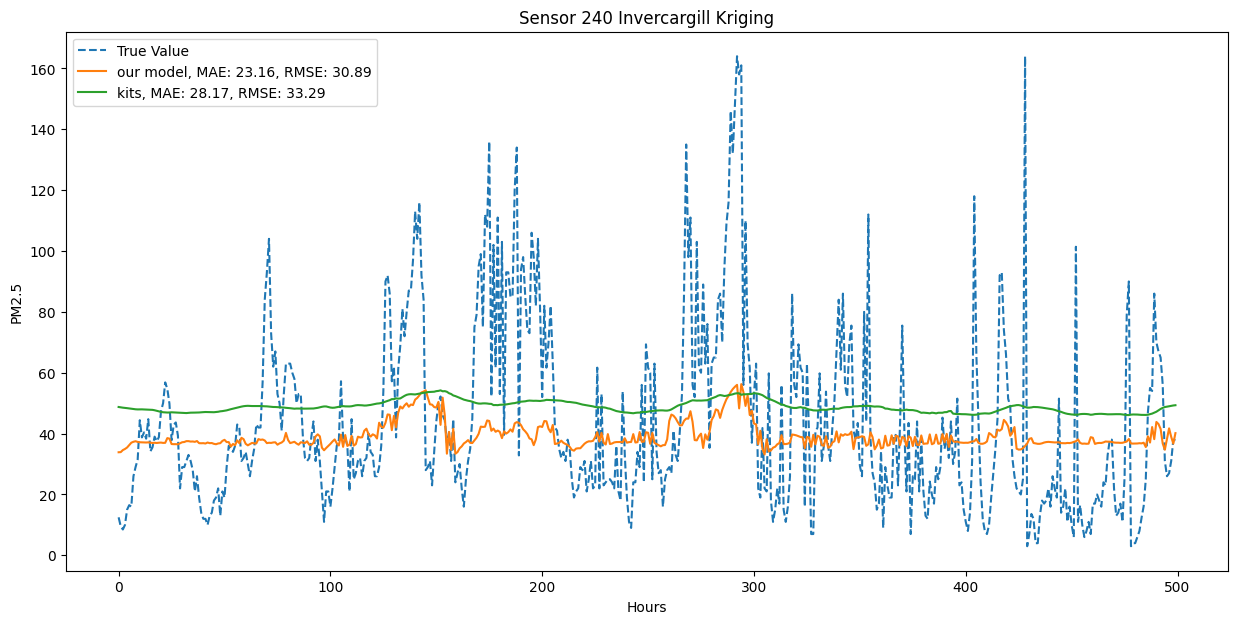

In [10]:
titles = ['our model', 'kits', 'ignnk', 'dida']
styles = ['-']
ranges = [1000, 1500]

sensors = [26, 126, 200, 21, 121, 18, 189, 50, 35, 182, 181, 180, 186, 59, 150, 8, 34, 185, 46, 66, 203, 149, 87, 100, 14, 86, 104, 112, 89, 151, 148, 172, 88, 202, 9, 51, 84, 204, 130, 41, 197, 77, 194, 43, 45, 44, 92, 153, 152, 146, 105, 120, 99, 158, 179, 131, 201, 167, 106, 82, 76, 11, 110, 178, 55, 173, 81, 62, 169]
sensors = [43, 45, 44, 92, 153, 152, 146, 105, 120, 99, 158, 179, 131, 201, 167, 106, 82, 76, 11, 110, 178, 55, 173, 81, 62, 169]
# sensors = [5, 10, 31, 40, 71, 73, 83, 117, 122, 156, 164, 176]
sensors = [3, 7, 10, 11, 12, 13, 15, 21, 24, 26, 27, 37, 38, 44, 51] #, 56, 57, 59, 61, 62, 64, 65, 67, 72, 74, 81, 86, 87, 92, 95, 98, 99, 106, 108, 112, 113, 116, 118, 124, 126, 127, 129, 133, 138, 140, 142, 144, 145, 149, 155, 168, 179, 183, 184, 185, 188, 191, 192, 196, 206]
sensors = [ 21, 156, 121,  35,  50, 200,  10, 179, 126, 189,  90,  18, 203,
            107,  44,  92, 183, 202, 152, 171,  99, 118,  45,   8,  55,  65]
sensors = [194, 125]
sensors = [4, 6, 7, 9, 12, 13, 16, 18, 24, 25, 31, 34, 35, 36, 39]
# sensors = [1, 5, 11, 14, 16, 26, 28, 34]
        # 3, 4, 5, 6, 12, 15, 16, 17, 19, 20, 22, 32, 33, 39, 57, 67, 68, 71, 72,
        # 74, 80, 91, 93, 94, 96, 97, 98, 102, 103, 118, 119, 124, 127, 128, 136, 138, 144
        # 154, 155, 157, 159, 160, 161, 162, 163, 166, 175, 187, 188, 190, 191, 192, 193, 195, 196, 198, 205, 206]
# sensors = range(1, 11)

# sensors = [1, 6, 12, 13, 19, 21, 29, 36, 37, 39, 49, 52, 53, 54, 55, 56, 58, 59, 62, 72, 74]
# sensors = [75, 77, 83, 84, 89, 95, 96, 100, 103, 105, 108, 109, 117, 119, 120, 122, 126, 133, 138, 139, 145, 149, 150, 153, 160, 161, 163, 165, 169, 170, 171, 196, 204, 206]

# all_s = [1, 6, 12, 13, 19, 21, 29, 36, 37, 39, 49, 52, 53, 54, 55, 56, 58, 59, 62, 72, 74] + [75, 77, 83, 84, 89, 95, 96, 100, 103, 105, 108, 109, 117, 119, 120, 122, 126, 133, 138, 139, 145, 149, 150, 153, 160, 161, 163, 165, 169, 170, 171, 196, 204, 206]

sensors = [240] 
        #    52, 53, 54, 55, 56, 58, 59, 62, 72, 74, 75, 77, 83, 84, 89, 95, 96, 100, 103, 105, 108, 109, 117, 119, 120, 122, 126, 133, 138, 139, 145, 149, 150, 153, 160, 161, 163, 165, 169, 170, 171, 196, 204, 206, 214, 220, 221, 226, 238, 239, 244, 247, 251, 252, 257, 261, 262, 263, 266, 269, 270, 278, 282, 285, 291, 297, 300, 301, 302, 306, 308, 309, 311, 316, 320, 324, 326, 327, 328, 332, 337, 344, 346, 349, 350, 362, 363, 365, 366, 381, 385, 387, 391, 398, 399, 407, 417, 418, 422, 427, 428, 436]

        #    [86, 87, 88, 89, 90, 99, 100, 104, 106, 112, 121, 124, 126, 130, 131, 134, 146, 148, 149, 150, 151, 152, 153, 158, 165, 170, 172, 174, 180, 181, 182, 184, 185, 186, 189, 197, 200, 202, 203, 204]


# deets = [[y_hat, y_true, mask, res, dm, dataset]]
mape_deet = [0, 0, 0, 0]
rmse_deet = [0, 0, 0, 0]

for sensor in sensors:
    plt.figure(figsize=(15,7))
    y_true = deets[0][1]

    # y_true = np.where(deets[0][2] == 1, y_true, 400)

    plt.plot(y_true[ranges[0]:ranges[1], -1, sensor, :], '--', label='True Value')
    # plt.plot(deets[1][0][ranges[0]:ranges[1], 0, 33, :], '--', label='KITS')
    for ind, deet in enumerate(deets):
        # deet = deets[0]
        y_hat = deet[0]
        print(y_hat.shape)
        test_mae=numpy_metrics.mae(y_hat[ranges[0]:ranges[1], :, sensor, :], 
                                    y_true[ranges[0]:ranges[1], :, sensor, :], deets[0][2][ranges[0]:ranges[1], :, sensor])
        test_rmse=numpy_metrics.rmse(y_hat[ranges[0]:ranges[1], :, sensor, :], 
                                    y_true[ranges[0]:ranges[1], :, sensor, :], deets[0][2][ranges[0]:ranges[1], :, sensor])

    # if test_mre > 20:
        plt.plot(y_hat[ranges[0]:ranges[1], -1, sensor, :], label=f'{titles[ind]}, MAE: {test_mae:.2f}, RMSE: {test_rmse:.2f}')
        mape_deet[ind] += test_mae
        rmse_deet[ind] += test_rmse
        # plt.plot(deet[1][ranges[0]:ranges[1], 0, 4, :], label=f'True Value')

    # plt.ylim((0, 100))
    plt.xlabel('Hours')
    plt.ylabel('PM2.5')
    plt.legend()
    plt.title(f'Sensor {sensor} Invercargill Kriging')
    plt.show()

In [19]:
y_hat[ranges[0]:ranges[1], -1, 240, :].squeeze(-1).shape

(500,)

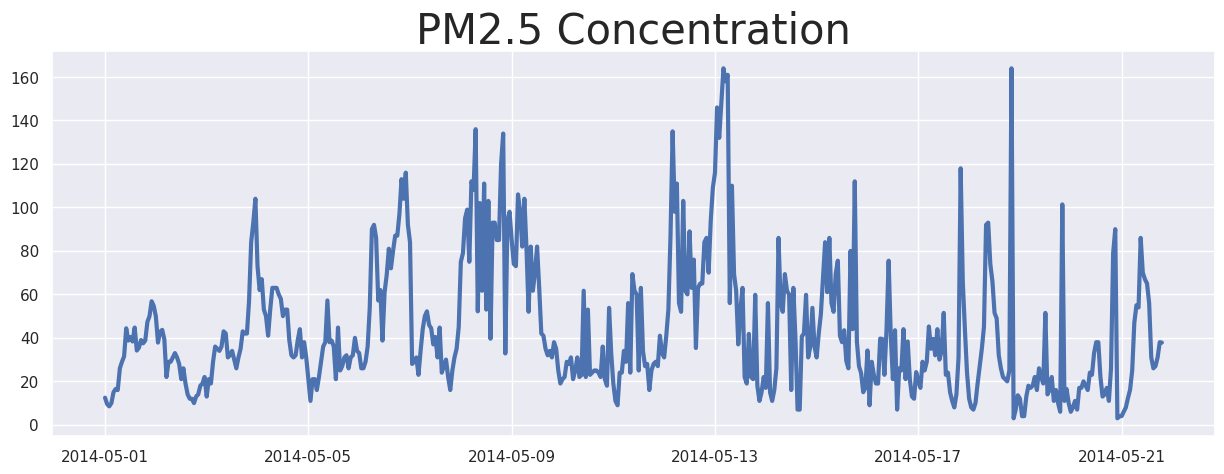

In [32]:
import seaborn as sns
import pandas as pd

leng = 500

y_hat = deets[0][1]

cur_data = pd.DataFrame({
    'x': dataset.dataframe().index[:leng],
    'y': y_hat[ranges[0]:ranges[1], -1, 240, :].squeeze(-1),
})

fig, ax = plt.subplots(figsize=(15, 5))
# sns.set_style("darkgrid")
sns.set_theme()
plot = sns.lineplot(data=cur_data, x = 'x', y="y", ax=ax, linewidth=3)
plot.set(xlabel=None, ylabel=None)
# plt.ylim(33, 57)
plt.title('PM2.5 Concentration', fontsize=30)
plt.show()
# plot.tick_params(left=False, bottom=False)